# Isoconversional analysis of solid-state reactions

## Copyrights

Developer: Yannis Vasilopoulos <br />
UCT Prague, June 2018 <br />
[Linkedin](https://www.linkedin.com/in/giannis-vasilopoulos/) <br />
Revisited at UCL, January 2020 <br />

## Modules Library

Import all the necessary modules

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from importlib import import_module
import csv
from scipy.misc import derivative
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from classes.input_data import Input_Data

## User-Defined Functions

In [2]:
# A function to calculate the conversion fraction
def conversion_fraction(m0,mf,mi):
    return (m0-mi)/(m0-mf)


# Limit the data based on the conversion fraction (y-array)
def limit(x,y,blim,ulim):
    
    y_tmp = [i for i in y if i >= blim]                           # Bottom limit of the y-array
    x_tmp = [x[i] for i in range(len(y)) if y[i] >= blim]         # Bottom limit the x-array
    y = [i for i in y_tmp if i <= ulim]                           # Upper limit the y-array
    x = [x_tmp[i] for i in range(len(y_tmp)) if y_tmp[i] <= ulim] # Upper limit the x-array
    
    return x,y

## Plotting settings

In [3]:
graph_format   = 'png'
graph_dpi      = 300
graph_fontsize = 11
lwidth         = 3
palette        = ['#2f4b7c','#a05195','#d45087','#9AD5CA','#C97064']
# palette      = ['#4c72b0','#dd8452','#55a868','#c44e52','#8172b3','#937860','#da8bc3','#8c8c8c','#ccb974','#64b5cd']
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')

## Directories

In [7]:
CWD       = os.getcwd()                                       # current working directory
DATA      = os.path.join(CWD,'data')                          # csv data files directory
Csvs      = [os.path.join(DATA,x) for x in os.listdir(DATA) if ".csv" in x] # list all the csv files in cwd
OUTPUT    = os.path.join(CWD,'output')                        # output directory
OUTPUT    = os.path.join(OUTPUT,'iso-analysis')

## Load Data

#### Read the data
* Get the the data recursively from the CSV files in `data` directory
* Read the thermogravimetric mass, time, temperature and temperature units from each data set

#### Convert the thermogravimetric mass to the conversion fraction

$$ \alpha = \frac{m_{0}-m_{t}}{m_{0}-m_{\infty}} $$

where $m_{0}$ is the initial mass, $m_{t}$ is the mass at time $t$ and $m_{\infty}$ is the final mass of the sample. Thus, $\alpha$ expresses the fraction of the mass that has been converted at a time $t$.

#### Set the limits of the conversion fraction (working data)

#### Perform a polynomial fitting

* Fit the $t = f(a)$ curve (referred as *inverse problem*). That enables us to calculate the time for an arbitrary conversion fraction
* Fit the $a = a(t) $ curve. That enables us to calculate the conversion fraction for an arbitrary time.
* Calculate the reaction rate based on the latter fit.

#### Plot for each individual kinetic data set
* The experimental conversion fraction and its polynomial fit over time
* The reaction rate over time
* The reaction rate over fraction reacted

In [54]:
# Create a list to store the instances in data = [instance #1, instance #2, ...]
data = []

for Csv in Csvs:
    
    # Read the CSV file
    df    = pd.read_csv(Csv) # open the CSV file as dataframe
    time        = df["Time (min)"].to_numpy()         # time
    mass        = df["TG (mg)"].to_numpy()            # thermogravimetric mass
    temperature = df["Temperature (C)"].to_numpy()    # temperature
    conversion  = df["Conversion"].to_numpy()         # conversion fraction
    time_units  = 'min'                               # time units
    
    # Limit the fitting region
    b_lim = 0.05 # bottom limit
    u_lim = 0.95 # upper limit
    
    # Get the updated region to fit
    t, a = limit(time, conversion, b_lim, u_lim)
    
    # Fit a polynomial to time as a function of the conversion fraction data (inverse)
    fit_degree    = 9                            # degree of the polynomial
    coefs         = np.polyfit(a,t,fit_degree)   # polynomial coefficients
    t_polynomial  = np.poly1d(coefs)             # the polynomial 
    a_inverse_fit = np.linspace(a[0],a[-1],2000) # interpolate to these new points
    t_inverse_fit = t_polynomial(a_inverse_fit)  # fit the function t = t(a) inverse of the original data 

    # Fit the conversion fraction with a polynomial for using the derivative dadt
    fit_degree   = 9                            # degree of the polynomial
    coefs        = np.polyfit(t,a,fit_degree)
    a_polynomial = np.poly1d(coefs)
    t_normal_fit = np.linspace(t[0],t[-1],2000) # interpolate to these new points
    a_normal_fit = a_polynomial(t_normal_fit)

    # Calculate the reaction rate based on the fitted conversion fraction
    dadt_poly = [derivative(a_polynomial,ti,dx=1e-6) for ti in t_normal_fit]
        
    instance = Input_Data(mass, t, time_units, temperature,
               a, a_inverse_fit, t_inverse_fit,
               t_polynomial, a_normal_fit, t_normal_fit, a_polynomial,
               dadt_poly)
        
    data.append(instance)

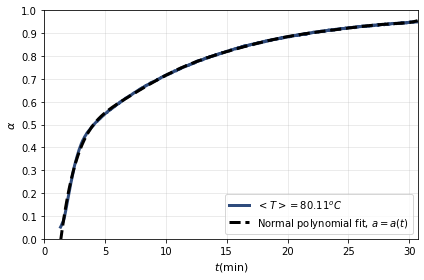

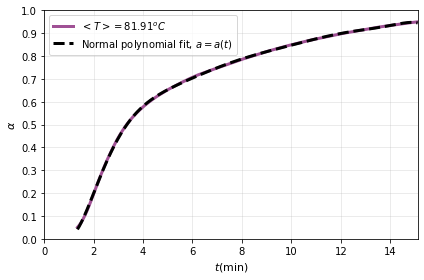

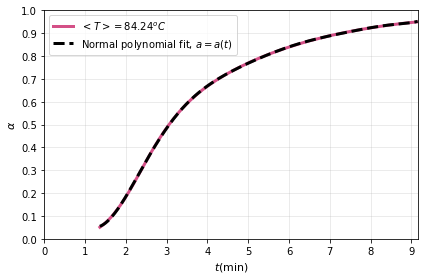

In [52]:
# Normal Fit Plots
for indx, exp_data in enumerate(data):
    
    fig = plt.figure()
    # Plot the conversion fraction versus time
    xplot = exp_data.time
    yplot = exp_data.conversion
    plt.plot(xplot,yplot,lw=lwidth,c=palette[indx],label=r'$ < T > = '+str(round(np.mean(exp_data.temperature),2))+' ^{o}C$')
    # Plot the fittef conversion fraction versus time from the normal fit
    xplot = exp_data.t_nrmfit
    yplot = exp_data.a_nrmfit
    # Plot
    plt.plot(xplot, yplot, lw=lwidth, ls='dashed', c='black', label=r'Normal polynomial fit, $ \alpha = p \left( t \right)$')
    plt.xlabel(r'$ t (\mathrm{'+exp_data.time_units+'}) $', fontsize=graph_fontsize)
    plt.ylabel(r'$ \alpha  $', fontsize=graph_fontsize)
    plt.xlim(0.0,max(xplot))
    plt.ylim(0.0, 1.0)
    plt.locator_params(axis='both', nbins=10)
    plt.grid(b=True, which='major', axis='both', alpha=0.3)
    plt.legend()
    plt.tight_layout()

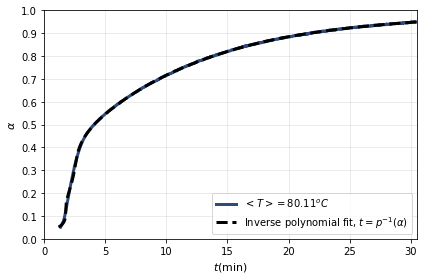

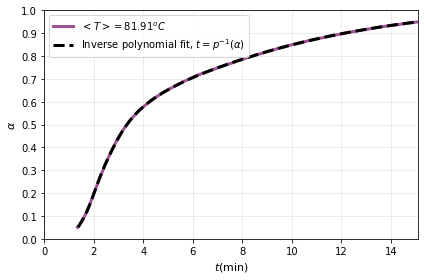

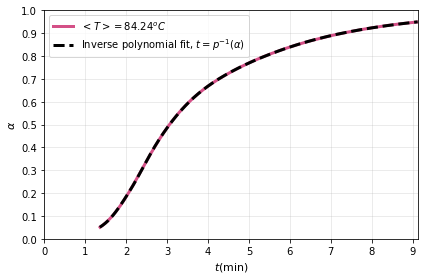

In [55]:
# Inverse Fit Plots
for indx, exp_data in enumerate(data):
    
    fig = plt.figure()
    # Plot the conversion fraction versus time
    xplot = exp_data.time
    yplot = exp_data.conversion
    plt.plot(xplot,yplot,lw=lwidth,c=palette[indx],label=r'$ < T > = '+str(round(np.mean(exp_data.temperature),2))+' ^{o}C$')
    # Plot the fittef conversion fraction versus time from the normal fit
    xplot = exp_data.t_invfit
    yplot = exp_data.a_invfit
    # Plot
    plt.plot(xplot, yplot, lw=lwidth, ls='dashed', c='black', label=r'Inverse polynomial fit, $t = p^{-1} \left( \alpha \right)$')
    plt.xlabel(r'$ t (\mathrm{'+exp_data.time_units+'}) $', fontsize=graph_fontsize)
    plt.ylabel(r'$ \alpha  $', fontsize=graph_fontsize)
    plt.xlim(0.0,max(xplot))
    plt.ylim(0.0, 1.0)
    plt.locator_params(axis='both', nbins=10)
    plt.grid(b=True, which='major', axis='both', alpha=0.3)
    plt.legend()
    plt.tight_layout()

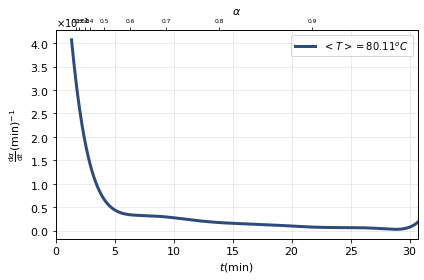

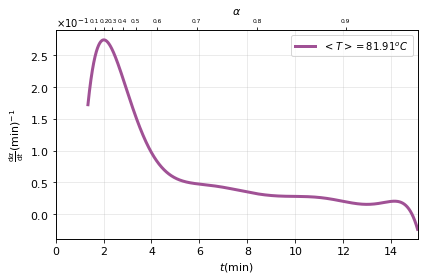

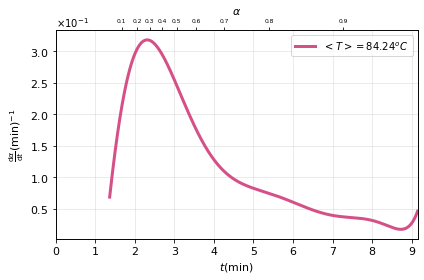

In [68]:
# Create necessary output directories
GRAPH = os.path.join(OUTPUT,'graphs') # output directory for the graphs
if not os.path.exists(GRAPH): os.makedirs(GRAPH)
    
# Get just the name of the csv files
csv_names = [x.split('.csv')[0] for x in os.listdir(DATA) if ".csv" in x]
    
# Plot the reaction rate from the normal fit
for indx, exp_data in enumerate(data):
    
    # Export a graph for the fitting of the integral reaction rate
    Plot = os.path.join(GRAPH,csv_names[indx]+'_dadt_vs_time.png')
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
    
    # Plot rhe reaction rate
    xplot = exp_data.t_nrmfit
    yplot = exp_data.rrate
    plt.plot(xplot,yplot,lw=lwidth,c=palette[indx],label=r'$ < T > = '+str(round(np.mean(exp_data.temperature),2))+' ^{o}C$')
    ax1.set_xlabel(r'$ t (\mathrm{'+exp_data.time_units+'}) $', fontsize=graph_fontsize)
    ax1.set_ylabel(r'$ \frac{ \mathrm{d} \alpha }{ \mathrm{d} t } \mathrm{('+exp_data.time_units+')^{-1}}  $', fontsize=graph_fontsize)
    ax1.set_xlim(0.0,max(xplot))
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    ax1.locator_params(axis='x', nbins=10)
    ax1.tick_params(direction='out', axis='both', labelsize=graph_fontsize)
    ax1.xaxis.set_minor_locator(MultipleLocator(10)) # make minor ticks multiples of 10
#         ax1.legend()
        
    # the conversion fraction levels that the reaction rate will be calculated for
    a_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    # the corresponding times for the above conversion
    t_levels = [exp_data.t_poly(i) for i in a_levels]

    # t_locations = the locations in the "normal fit" arrays
    #               that correspond to the above defined times
    t_locations = []
    for i in t_levels:
        t_norm = [abs(i-j) for j in exp_data.t_nrmfit]
        t_loc  = np.argmin(t_norm)
        t_locations.append(t_loc)

    # the new time levels based on the 'normal fit'
    t_levels = [exp_data.t_nrmfit[i] for i in t_locations]

    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(t_levels)
    ax2.set_xticklabels(a_levels)
    ax2.set_xlabel(r'$ \alpha $', fontsize=graph_fontsize)
    ax2.tick_params(direction='out', axis='x', labelsize=graph_fontsize-5)
    ax1.grid(b=True, which='major', axis='both', alpha=0.3)
    plt.tight_layout()
    plt.legend()
    plt.savefig(Plot, format=graph_format, dpi=graph_dpi)

In [66]:
xxx = [x.split('.csv')[0] for x in os.listdir(DATA) if ".csv" in x] # list all the csv files in cwd

In [67]:
xxx

['80_0_Celcius', '82_5_Celcius', '85_0_Celcius']

In [ ]:
for i_file in range(len(csv_files)):
    
    # Create a directory for the particular CSV data file to export files in
    csv_path = os.path.join(output_path,csv_names[i_file])
    if not os.path.exists(csv_path): os.makedirs(csv_path)
        
    # Plot the conversion fraction over time for each data
    plotname = 'a_vs_t_nrmfit.'+file_format
    if not os.path.isfile(os.path.join(csv_path,plotname)):
        fig = plt.figure()
        
#         # Limit the conversion fraction for plotting purposes
#         # Limit the experimental conversion fraction
#         y_plot = [x for x in indata[i_file].conversion if x >= b_lim]
#         y_plot = [x for x in indata[i_file].conversion if x <= u_lim]
#         # Limit experimental conversion fraction's time
#         x_plot = [indata[i_file].time[i] for i in range(len(indata[i_file].conversion)) if indata[i_file].conversion[i] >= b_lim]
#         x_plot = [indata[i_file].time[i] for i in range(len(indata[i_file].conversion)) if indata[i_file].conversion[i] <= u_lim]
        
        # Plot
        x_plot = indata[i_file].conversion
        y_plot = indata[i_file].time
        plt.plot(x_plot, y_plot, lw=lwidth, c=palette[i_file], label='$T = '+str(indata[i_file].temperature)+' ^{o}C$')
        
#         # Limit the conversion fraction for plotting purposes
#         # Limit the experimental conversion fraction
#         y_plot = [x for x in indata[i_file].a_nrmfit if x >= b_lim]
#         y_plot = [x for x in indata[i_file].a_nrmfit if x <= u_lim]
#         # Limit experimental conversion fraction's time
#         x_plot = [indata[i_file].t_nrmfit[i] for i in range(len(indata[i_file].a_nrmfit)) if indata[i_file].a_nrmfit[i] >= b_lim]
#         x_plot = [indata[i_file].t_nrmfit[i] for i in range(len(indata[i_file].a_nrmfit)) if indata[i_file].a_nrmfit[i] <= u_lim]
        

    
        x_plot = indata[i_file].a_nrmfit
        y_plot = indata[i_file].t_nrmfit
        # Plot
        plt.plot(x_plot, y_plot, lw=lwidth, ls='dashed', c='black', label='Polynomial fit')
        
        plt.xlabel(r'$ t (\mathrm{'+indata[0].units+'}) $', fontsize=font_size)
        plt.ylabel(r'$ \alpha  $', fontsize=font_size)
        plt.xlim(0.0,max(x_plot))
        plt.ylim(0.0, 1.0)
        plt.locator_params(axis='both', nbins=10)
        plt.grid(b=True, which='major', axis='both', alpha=0.3)
        plt.legend()
        plt.tight_layout()
#         plt.savefig(plotname, format=file_format, dpi=dpi)
#         os.rename(plotname, os.path.join(csv_path,plotname))

    # Plot the conversion fraction over time for each data
    plotname = 'a_vs_t_invfit.'+file_format
    if not os.path.isfile(os.path.join(csv_path,plotname)):
        fig = plt.figure()
        
#         # Limit the conversion fraction for plotting purposes
#         # Limit the experimental conversion fraction
#         y_plot = [x for x in indata[i_file].conversion if x >= b_lim]
#         y_plot = [x for x in indata[i_file].conversion if x <= u_lim]
#         # Limit experimental conversion fraction's time
#         x_plot = [indata[i_file].time[i] for i in range(len(indata[i_file].conversion)) if indata[i_file].conversion[i] >= b_lim]
#         x_plot = [indata[i_file].time[i] for i in range(len(indata[i_file].conversion)) if indata[i_file].conversion[i] <= u_lim]

        x_plot = indata[i_file].conversion
        y_plot = indata[i_file].time
        
        # Plot
        plt.plot(x_plot, y_plot, lw=lwidth, c=palette[i_file], label='$T = '+str(indata[i_file].temperature)+' ^{o}C$')
        
        # Limit the conversion fraction for plotting purposes
        # Limit the experimental conversion fraction
        y_plot = [x for x in indata[i_file].a_invfit if x >= b_lim]
        y_plot = [x for x in indata[i_file].a_invfit if x <= u_lim]
        # Limit experimental conversion fraction's time
        x_plot = [indata[i_file].t_invfit[i] for i in range(len(indata[i_file].a_invfit)) if indata[i_file].a_invfit[i] >= b_lim]
        x_plot = [indata[i_file].t_invfit[i] for i in range(len(indata[i_file].a_invfit)) if indata[i_file].a_invfit[i] <= u_lim]
        
        x_plot = indata[i_file].a_invfit
        y_plot = indata[i_file].t_invfit
        
        # Plot
        plt.plot(x_plot, y_plot, lw=lwidth, ls='dashed', c='black', label='Polynomial fit')
        
        plt.xlabel(r'$ t (\mathrm{'+indata[0].units+'}) $', fontsize=font_size)
        plt.ylabel(r'$ \alpha  $', fontsize=font_size)
        plt.xlim(0.0,max(x_plot))
        plt.ylim(0.0, 1.0)
        plt.locator_params(axis='both', nbins=10)
        plt.grid(b=True, which='major', axis='both', alpha=0.3)
        plt.legend()
        plt.tight_layout()
#         plt.savefig(plotname, format=file_format, dpi=dpi)
#         os.rename(plotname, os.path.join(csv_path,plotname))
        
    # Plot the reaction rate over time with the conversion fraction info on top
    plotname = 'dadt_vs_t.'+file_format
    if not os.path.isfile(os.path.join(csv_path,plotname)):
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax2 = ax1.twiny()

#         # Limit the the plot according to the conversion fraction limits
#         # Limit the fitted time
#         x_plot = [indata[i_file].t_nrmfit[i] for i in range(len(indata[i_file].a_nrmfit)) if indata[i_file].a_nrmfit[i] >= b_lim]
#         x_plot = [indata[i_file].t_nrmfit[i] for i in range(len(indata[i_file].a_nrmfit)) if indata[i_file].a_nrmfit[i] <= u_lim]
#         # Limit the reaction rate
#         y_plot = [indata[i_file].rrate[i] for i in range(len(indata[i_file].a_nrmfit)) if indata[i_file].a_nrmfit[i] >= b_lim]
#         y_plot = [indata[i_file].rrate[i] for i in range(len(indata[i_file].a_nrmfit)) if indata[i_file].a_nrmfit[i] <= u_lim]

        # Plot
        x_plot = indata[i_file].t_nrmfit
        y_plot = indata[i_file].rrate
        plt.plot(x_plot, y_plot, lw=lwidth, c=palette[i_file], label='$T = '+str(indata[i_file].temperature)+' ^{o}C$')
        
        
        ax1.set_xlabel(r'$ t (\mathrm{'+indata[0].units+'}) $', fontsize=font_size)
        ax1.set_ylabel(r'$ \frac{ \mathrm{d} \alpha }{ \mathrm{d} t } \mathrm{('+indata[0].units+')^{-1}}  $', fontsize=font_size)
        ax1.set_xlim(0.0,max(x_plot))
        ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
        ax1.locator_params(axis='x', nbins=10)
        ax1.tick_params(direction='out', axis='both', labelsize=font_size)
        ax1.xaxis.set_minor_locator(MultipleLocator(10)) # make minor ticks multiples of 10
#         ax1.legend()
        
        # the conversion fraction levels that the reaction rate will be calculated for
        a_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        # the corresponding times
        t_levels = [indata[i_file].t_poly(i) for i in a_levels]

        # t_locations = the locations in the "normal fit" arrays
        #               that correspond to the above defined times
        t_locations = []
        for i in t_levels:
            t_norm = [abs(i-j) for j in indata[i_file].t_nrmfit]
            t_loc  = np.argmin(t_norm)
            t_locations.append(t_loc)
        
        # the new time levels based on the 'normal fit'
        t_levels = [indata[i_file].t_nrmfit[i] for i in t_locations]

        ax2.set_xlim(ax1.get_xlim())
        ax2.set_xticks(t_levels)
        ax2.set_xticklabels(a_levels)
        ax2.set_xlabel(r'$ \alpha $', fontsize=font_size)
        ax2.tick_params(direction='out', axis='x', labelsize=font_size-5)
        ax1.grid(b=True, which='major', axis='both', alpha=0.3)
        plt.tight_layout()
        plt.legend()
        plt.savefig(plotname, format=file_format, dpi=dpi)
        os.rename(plotname, os.path.join(csv_path,plotname))

    # Plot the reaction rate over the conversion fraction for each data
    plotname = 'dadt_vs_a.'+file_format
    if not os.path.isfile(os.path.join(csv_path,plotname)):
        fig = plt.figure()
        
#         # Limit the the plot according to the conversion fraction limits
#         # Limit the fitted time
#         x_plot = [indata[i_file].a_nrmfit[i] for i in range(len(indata[i_file].a_nrmfit)) if indata[i_file].a_nrmfit[i] >= b_lim]
#         x_plot = [indata[i_file].a_nrmfit[i] for i in range(len(indata[i_file].a_nrmfit)) if indata[i_file].a_nrmfit[i] <= u_lim]
#         # Limit the reaction rate
#         y_plot = [indata[i_file].rrate[i] for i in range(len(indata[i_file].a_nrmfit)) if indata[i_file].a_nrmfit[i] >= b_lim]
#         y_plot = [indata[i_file].rrate[i] for i in range(len(indata[i_file].a_nrmfit)) if indata[i_file].a_nrmfit[i] <= u_lim]
        
        # Plot
        
        x_plot = indata[i_file].a_nrmfit
        y_plot = indata[i_file].rrate
        plt.plot(x_plot, y_plot, lw=lwidth, c=palette[i_file], label='$T = '+str(T)+' ^{o}C$')
        
        plt.xlabel(r'$ \alpha $', fontsize=font_size)
        plt.ylabel(r'$ \frac{ \mathrm{d} \alpha }{ \mathrm{d} t } \mathrm{('+indata[0].units+')^{-1}} $', fontsize=font_size)
        plt.xlim(0.0,1.0)
        plt.locator_params(axis='x', nbins=10)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
        plt.grid(b=True, which='major', axis='both', alpha=0.3)
        plt.legend()

        plt.tight_layout()
        plt.savefig(plotname, format=file_format, dpi=dpi)
        os.rename(plotname, os.path.join(csv_path,plotname))

In [ ]:
# Create a directory for the overall analysis
overall_path = os.path.join(output_path,'overall')
if not os.path.exists(overall_path): os.makedirs(overall_path)
    
# Plot the conversion fraction over time for all data
plotname = 'a_vs_t.'+file_format

if not os.path.isfile(os.path.join(overall_path,plotname)):
    fig = plt.figure()

    for i_file in range(len(csv_files)):
        
        # Limit the conversion fraction for plotting purposes
        # Limit the experimental conversion fraction
        y_plot = [x for x in indata[i_file].conversion if x >= b_lim]
        y_plot = [x for x in indata[i_file].conversion if x <= u_lim]
        # Limit experimental conversion fraction's time
        x_plot = [indata[i_file].time[i] for i in range(len(indata[i_file].conversion)) if indata[i_file].conversion[i] >= b_lim]
        x_plot = [indata[i_file].time[i] for i in range(len(indata[i_file].conversion)) if indata[i_file].conversion[i] <= u_lim]

        # Plot
        plt.plot(x_plot, y_plot, lw=lwidth, c=palette[i_file], label='$T = '+str(indata[i_file].temperature)+' ^{o}C$')

    plt.xlabel(r'$ t (\mathrm{'+indata[0].units+'}) $', fontsize=font_size)
    plt.ylabel(r'$ \alpha  $', fontsize=font_size)
#     plt.xlim(0.0,max(x_plot))
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylim(0.0, 1.0)
    plt.locator_params(axis='both', nbins=10)
    plt.grid(b=True, which='major', axis='both', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(plotname, format=file_format, dpi=dpi)
    os.rename(plotname, os.path.join(overall_path,plotname))

In [ ]:
# Plot the reaction rate over time for all data
plotname = 'dadt_vs_t.'+file_format

if not os.path.isfile(os.path.join(overall_path,plotname)):
    fig = plt.figure()

    for i_file in range(len(csv_files)):
        
        # Limit the the plot according to the conversion fraction limits
        # Limit the fitted time
        x_plot = [indata[i_file].t_nrmfit[i] for i in range(len(indata[i_file].a_nrmfit)) if indata[i_file].a_nrmfit[i] >= b_lim]
        x_plot = [indata[i_file].t_nrmfit[i] for i in range(len(indata[i_file].a_nrmfit)) if indata[i_file].a_nrmfit[i] <= u_lim]
        # Limit the reaction rate
        y_plot = [indata[i_file].rrate[i] for i in range(len(indata[i_file].a_nrmfit)) if indata[i_file].a_nrmfit[i] >= b_lim]
        y_plot = [indata[i_file].rrate[i] for i in range(len(indata[i_file].a_nrmfit)) if indata[i_file].a_nrmfit[i] <= u_lim]

        # Plot
        plt.plot(x_plot, y_plot, lw=lwidth, c=palette[i_file], label='$T = '+str(indata[i_file].temperature)+' ^{o}C$')

    plt.xlabel(r'$ t (\mathrm{'+indata[0].units+'}) $', fontsize=font_size)
    plt.ylabel(r'$ \frac{ \mathrm{d} \alpha }{ \mathrm{d} t } \mathrm{('+indata[0].units+')^{-1}}  $', fontsize=font_size)
#     plt.xlim(0.0,)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylim(0.0,)
    plt.locator_params(axis='x', nbins=10)
    plt.grid(b=True, which='major', axis='both', alpha=0.3)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(plotname, format=file_format, dpi=dpi)
    os.rename(plotname, os.path.join(overall_path,plotname))

In [ ]:
# Plot the reaction rate over the conversion fraction for all data
plotname = 'dadt_vs_a.'+file_format

if not os.path.isfile(os.path.join(overall_path,plotname)):
    fig = plt.figure()

    for i_file in range(len(csv_files)):
        
        # Limit the the plot according to the conversion fraction limits
        # Limit the fitted time
        x_plot = [indata[i_file].a_nrmfit[i] for i in range(len(indata[i_file].a_nrmfit)) if indata[i_file].a_nrmfit[i] >= b_lim]
        x_plot = [indata[i_file].a_nrmfit[i] for i in range(len(indata[i_file].a_nrmfit)) if indata[i_file].a_nrmfit[i] <= u_lim]
        # Limit the reaction rate
        y_plot = [indata[i_file].rrate[i] for i in range(len(indata[i_file].a_nrmfit)) if indata[i_file].a_nrmfit[i] >= b_lim]
        y_plot = [indata[i_file].rrate[i] for i in range(len(indata[i_file].a_nrmfit)) if indata[i_file].a_nrmfit[i] <= u_lim]

        # Plot
        plt.plot(x_plot, y_plot, lw=lwidth, c=palette[i_file], label='$T = '+str(indata[i_file].temperature)+' ^{o}C$')

    plt.xlabel(r'$ \alpha $', fontsize=font_size)
    plt.ylabel(r'$ \frac{ \mathrm{d} \alpha }{ \mathrm{d} t } \mathrm{('+indata[0].units+')^{-1}} $', fontsize=font_size)
    plt.xlim(0.0,1.0)
#     plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylim(0.0,)
    plt.locator_params(axis='x', nbins=10)
    plt.grid(b=True, which='major', axis='both', alpha=0.3)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(plotname, format=file_format, dpi=dpi)
    os.rename(plotname, os.path.join(overall_path,plotname))

In [ ]:
# Plot the natural logarithm of the reaction rate over the inverse temperature
# FOR ILLUSTRATION PURPOSES

plotname = 'logdadt_vs_invT.'+file_format

if not os.path.isfile(os.path.join(overall_path,plotname)):    

    fig = plt.figure()

    for i_file in range(len(csv_files)):

        # the conversion fraction levels that the reaction rate will be calculated for
        a_levels = [0.1, 0.3, 0.5, 0.7, 0.9]
        # the corresponding times
        t_levels = [indata[i_file].t_poly(i) for i in a_levels]

        # t_locations = the locations in the "normal fit" arrays
        #               that correspond to the above defined times
        t_locations = []
        for i in t_levels:
            t_norm = [abs(i-j) for j in indata[i_file].t_nrmfit]
            t_loc  = np.argmin(t_norm)
            t_locations.append(t_loc)

        y = [] # it will hold the inverse temperature [size(t_location)]
        x = [] # it will hold the natural logarithm of the reaction rate [size(t_location)]

        for ti in t_locations:
            # calculate the reactin rate for a particular conversion level
            y.append(indata[i_file].rrate[ti])
            # draw out the corresponding temperature
            x.append(indata[i_file].temperature)

        x = [1.0/i for i in x]
        y = [np.log(i) for i in y]

        for i in range(len(t_locations)):
            # comment: in this plot the temperature remains the same so as y[i]
            #          fills up the graph with reaction rates at different conversions
            #          the different colours correspond to different temperatures
            #          while the different marker styles correspond to different conversion levels
            plt.scatter(x[i],y[i],c=palette[i_file],marker=filled_markers[i],s=70,edgecolors='black')

    # limits for the graph to have it more generic
    T_lim = []

    for i in range(len(csv_files)):
        T_lim.append(indata[i].temperature)

    T_lim = [1.0/i for i in T_lim]

    plt.xlabel(r'$  1/T \mathrm{(K^{-1})} $', fontsize=font_size)
    plt.ylabel(r'$ \ln{ \left( \frac{ \mathrm{d} \alpha }{ \mathrm{d} t} \right) } \mathrm{('+indata[0].units+')^{-1}} $', fontsize=font_size)
    plt.grid(b=True, which='major', axis='both', alpha=0.3)
    plt.tight_layout()
    plt.xlim(min(T_lim)-0.1*np.mean(T_lim),max(T_lim)+0.1*np.mean(T_lim))
    plt.savefig(plotname, format=file_format, dpi=dpi)
    os.rename(plotname, os.path.join(overall_path,plotname))

In [ ]:
# Create a class to store the locations
# of the 'normal fit' time array where the conversion fraction
# is defined explicitly
class t_locs:

    def __init__(self, t_locations):
        self.t_locations = t_locations

# Define the conversion fraction levels where the isoconverional method
# will be implemented at
a_levels = np.linspace(b_lim,u_lim,2000)

# Create an instances array
# t_indx = [instance #1, instance #2, ...]

t_indx = []
for i_file in range(len(csv_files)):
    
    # The corresponding times of the a_levels
    t_levels = [indata[i_file].t_poly(i) for i in a_levels]

    # t_locations = the locations in the "normal fit" arrays
    #               that correspond to the above defined times
    t_locations = []
    for i in t_levels:
        t_norm = [abs(i-j) for j in indata[i_file].t_nrmfit]
        t_loc  = np.argmin(t_norm)
        t_locations.append(t_loc)
    
    # Create the instances
    t_indx.append(t_locs(t_locations))

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Perform linar regression for each data set ( ln(reaction rate) vs inverse temperature )
# over all the explicitly defined conversion fraction levels

Ea        = [] # Activation energy (kJ/mol)
intercept = [] # Intercept ln[A f(a)]
MSE       = [] # Standard deviation
R2        = [] # Determination coefficient

for i_isoc in range(len(t_locations)):

    y = []

    for i_file in range(len(csv_files)):
        ti = t_indx[i_file].t_locations[i_isoc]
        y.append(indata[i_file].rrate[ti])

    # natural logarithm of the reaction rate
    y = [np.log(i) for i in y]

    # inverse temperature
    x = []
    for i_file in range(len(csv_files)):
        x.append(indata[i_file].temperature)

    x = [1.0/i for i in x]

    # Calling DataFrame constructor after zipping 
    # both lists, with columns specified
    df = pd.DataFrame(list(zip(x,y)), columns =['x','y'],dtype=float)

    regr = LinearRegression()
    x_train = np.asanyarray(df[['x']])
    y_train = np.asanyarray(df[['y']])
    regr.fit (x_train, y_train)

    y_pred = regr.predict(x_train)

    Ea.append(-regr.coef_[0][0])
    intercept.append(regr.intercept_[0])
    MSE.append(mean_squared_error(y_train, y_pred))
    R2.append(r2_score(y_pred , y_train))

In [ ]:
# Plot the conversion fraction over time for each data
plotname = 'Ea_vs_a.'+file_format

x_plot = a_levels
y_plot = Ea
if not os.path.isfile(os.path.join(overall_path,plotname)):
    fig = plt.figure()
    plt.plot(x_plot, y_plot, lw=lwidth, c=palette[0])
    plt.xlabel(r'$ \alpha $', fontsize=font_size)
    plt.ylabel(r'$ E_{\alpha} \mathrm{(kJ \cdot mol^{-1})} $', fontsize=font_size)
    plt.xlim(0.0,1.0)
#     plt.autoscale(enable=True, axis='x', tight=True)
#     plt.ylim(0.0,)
    plt.locator_params(axis='x', nbins=10)
    plt.grid(b=True, which='major', axis='both', alpha=0.3)
#     plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
#     plt.legend()
    plt.tight_layout()
    plt.savefig(plotname, format=file_format, dpi=dpi)
    os.rename(plotname, os.path.join(overall_path,plotname))

In [ ]:
# Plot the conversion fraction over time for each data
plotname = 'intercept_vs_a.'+file_format

x_plot = a_levels
y_plot = intercept
if not os.path.isfile(os.path.join(overall_path,plotname)):
    fig = plt.figure()
    plt.plot(x_plot, y_plot, lw=lwidth, c=palette[0])
    plt.xlabel(r'$ \alpha $', fontsize=font_size)
    plt.ylabel(r'$ \ln[A f(\alpha)] $', fontsize=font_size)
    plt.xlim(0.0,1.0)
#     plt.autoscale(enable=True, axis='x', tight=True)
#     plt.ylim(0.0,)
    plt.locator_params(axis='x', nbins=10)
    plt.grid(b=True, which='major', axis='both', alpha=0.3)
#     plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
#     plt.legend()
    plt.tight_layout()
    plt.savefig(plotname, format=file_format, dpi=dpi)
    os.rename(plotname, os.path.join(overall_path,plotname))